In [70]:
pip install tensorflow_decision_forests

In [105]:
import pandas as pd
import tensorflow_decision_forests as tfdf
import matplotlib.pyplot as plt
import numpy as np
import imblearn
from imblearn.under_sampling import RandomUnderSampler

In [72]:
df = pd.read_csv('../content/datasets/car_evaluation.csv')

In [73]:
label = "class"

classes = df[label].unique().tolist()
print(f"Label : {classes}")

df[label] = df[label].map(classes.index)

Label : ['unacc', 'acc', 'vgood', 'good']


In [ ]:

#X = df.drop(['class'], axis=1)
#y = df['class']
#ran = RandomUnderSampler()
#X_rs, y_rs = ran.fit_resample(X,y)

In [74]:
def split_dataset(dataset, test_ratio=0.20):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]


train_ds_pd, test_ds_pd = split_dataset(df)
print("{} data utk training, {} data utk testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

1376 data utk training, 352 data utk testing.


In [93]:
train_ds_pd['class'].value_counts()

class
0    970
1    302
3     54
2     50
Name: count, dtype: int64

In [85]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=label)

In [98]:
tuner = tfdf.tuner.RandomSearch(num_trials=20)
tuner.choice("num_candidate_attributes_ratio", [1.0, 0.8, 0.6])
tuner.choice("use_hessian_gain", [True, False])

tuner.choice("max_depth", [2, 3, 5, 6, 8, 10, 20])

In [103]:
#model = tfdf.keras.GradientBoostedTreesModel(num_trees=500,
                                             #growing_strategy="BEST_FIRST_GLOBAL",
                                             #max_depth=8,
                                             #split_axis="SPARSE_OBLIQUE",
                                             #categorical_algorithm="RANDOM",)

model = tfdf.keras.GradientBoostedTreesModel()
training = model.fit(train_ds)

Use /tmp/tmpw32yio1m as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.182413. Found 1376 examples.
Training model...
Model trained in 0:00:00.428707
Compiling model...
Model compiled.


In [102]:
model.compile(metrics=["accuracy"])
evaluation = model.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.6f}")

1/1 [==============================] - 0s 270ms/step - loss: 0.0000e+00 - accuracy: 0.7301

loss: 0.000000
accuracy: 0.730114


In [88]:
model.summary()

Model: "gradient_boosted_trees_model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (4):
	buying
	lug_boot
	maint
	safety

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.   "safety"  0.635135 ################
    2.   "buying"  0.406322 ######
    3.    "maint"  0.359370 ####
    4. "lug_boot"  0.256122 

Variable Importance: NUM_AS_ROOT:
    1.   "safety" 141.000000 ################
    2.    "maint" 32.000000 ##
    3. "lug_boot"  8.000000 
    4.   "buying"  7.000000 

Variable Importance: NUM_NODES:
    1.   "safety" 777.000000 ################
    2.    "maint" 702.000000 #######
    3.   "buying" 699.000000 #######
    4. "lug_boot" 636.0

In [83]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0, max_depth=5)

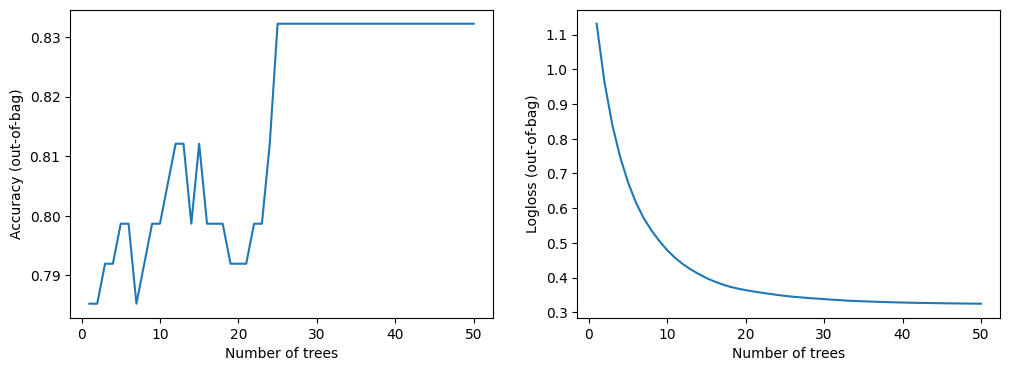

In [84]:
logs = model.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()